<a href="https://colab.research.google.com/github/guber25/Forecasting_w_Sentiment/blob/main/Preprocessing_and_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IS IT POSSIBLE TO IMPROVE THE FORECASTS OF THE S&P 500 WITH SENTIMENT ANALYSIS?**

#### **TEXT MINING AND SENTIMENT ANALYSIS PROJECT**

##University of Milan

### Author: Guglielmo Berzano
#### email: guglielmo.berzano@studenti.unimi.it
#### Academic year: 2023-2024

Dataset: [Financial News](https://www.kaggle.com/datasets/notlucasp/financial-news-headlines)



The first step is to install VADER, one of the two models used in this project, then mount to google drive and lastly to import the libraries

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import yfinance as yf
from datetime import datetime as dt
import seaborn as sns
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 15})

Mounted at /content/drive


In [ ]:
sp500 = yf.Ticker("^GSPC").history(period="10y")
sp500["Date"]=sp500.index
sp500 = sp500[(sp500["Date"]>="2017-12-17") & (sp500["Date"]<="2020-07-18")].copy()
sp500.reset_index(drop=True, inplace=True)
sp500.drop(["High", "Low", "Volume", "Dividends", "Stock Splits"], axis=1, inplace=True) #keeping just the Open, Close and Date columns

sp500["Date"] = sp500["Date"].apply(lambda x: x.strftime("%Y-%m-%d"))

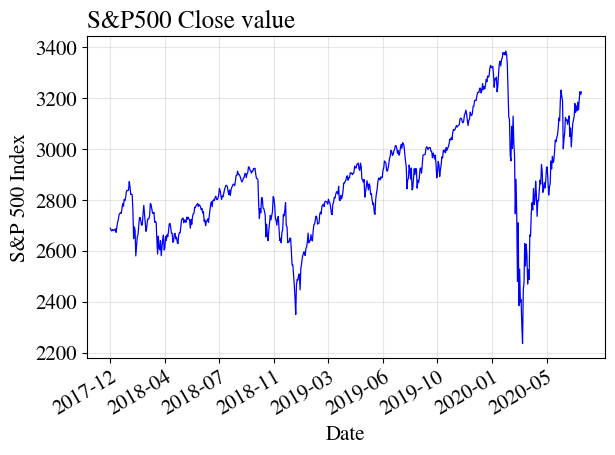

In [36]:
sp500["Close"].plot(lw=.9,color="blue")
plt.title("S&P500 Close value", loc='left')
plt.ylabel("S&P 500 Index")
plt.xlabel("Date")
plt.xticks(np.arange(0, 649,75), labels = pd.Series([str(i) for i in pd.Series(sp500["Date"])[::75]]).apply(lambda x: x[0:7]),
           rotation=30, ha='right', rotation_mode='anchor')
plt.grid(alpha=.3)
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/Text mining/sp500_close.pdf")

In [ ]:
#importing all the dataframes

def day_month_year_cnbc(value):
  try:
    dt.strptime(value.strip(), "%I:%M %p ET %a, %d %B %Y")
    return dt.strptime(value.strip(), "%I:%M %p ET %a, %d %B %Y").strftime("%Y-%m-%d")
  except ValueError:
    return "error"


reuters = pd.read_csv("/content/drive/MyDrive/Text mining/reuters_headlines.csv")
reuters.Time = reuters.Time.apply(lambda x: dt.strptime(x, "%b %d %Y").strftime("%Y-%m-%d"))
reuters.drop("Description", axis=1, inplace=True)
reuters.reset_index(drop=True, inplace=True)

cnbc= pd.read_csv("/content/drive/MyDrive/Text mining/cnbc_headlines.csv")
cnbc.dropna(axis=0, inplace=True)
cnbc.Time = cnbc.Time.apply(day_month_year_cnbc)
cnbc.drop(labels=cnbc[cnbc.Time=="error"].index, axis=0, inplace=True)
cnbc.drop("Description", axis=1, inplace=True)
cnbc.reset_index(drop=True, inplace=True)

guardian = pd.read_csv("/content/drive/MyDrive/Text mining/guardian_headlines.csv")
guardian = guardian[guardian['Time'].astype(str).str.len() >= 7].copy()
guardian.Time = guardian.Time.apply(lambda x: dt.strptime(x, "%d-%b-%y").strftime("%Y-%m-%d"))

In [ ]:
#Number of news contained in each dataset
reuters.shape, cnbc.shape, guardian.shape

((32770, 2), (1276, 2), (17760, 2))

In [ ]:
#Creating the news dataset
news = pd.concat([cnbc, reuters, guardian], ignore_index=True)
news.sort_values(by="Time", inplace=True)
news.reset_index(drop=True, inplace=True)
news['Headlines'] = news['Headlines'].str.replace("\n", "")

news.head()

,Headlines,Time
0,The Guardian view on Ryanair’s model: a union-...,2017-12-17
1,Peter Preston on press and broadcasting Pau...,2017-12-17
2,Why business could prosper under a Corbyn gove...,2017-12-17
3,Youngest staff to be given UK workplace pensio...,2017-12-17
4,Grogonomics This year has been about compan...,2017-12-17
...,...,...
51801,TikTok considers London and other locations fo...,2020-07-18
51802,Twitter says attackers downloaded data from up...,2020-07-18
51803,Trail of missing Wirecard executive leads to B...,2020-07-18
51804,Boohoo calls for licensing scheme to ensure te...,2020-07-18


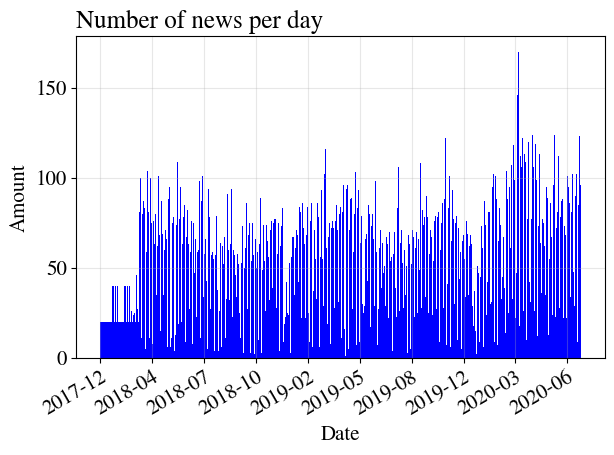

In [ ]:
plt.hist(news.Time, bins=926, color="blue")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title("Number of news per day", loc="left")
plt.grid(alpha=.3)
plt.xticks(np.arange(0, 926, step=100), labels = pd.Series(news.Time.unique()[::100]).apply(lambda x: x[0:7]), rotation=30, ha='right', rotation_mode='anchor') #927 unique items
plt.tight_layout()
#plt.show()
plt.savefig("/content/drive/MyDrive/Text mining/news_per_day.pdf")

In [ ]:
# Avg number of news published per day
np.average(news.groupby(by=['Time'])["Headlines"].count())

55.8856526429342

## FINBERT

The FinBERT model will be applied to the Headline column and the result will be stored in the column Sentiment_F2

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'Negative', 'score': 0.9966173768043518}, {'label': 'Positive', 'score': 1.0}, {'label': 'Negative', 'score': 0.9999710321426392}, {'label': 'Neutral', 'score': 0.9889441728591919}]


In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sentiment_finbert2 = []
sentiment_finbert2 = nlp(news.Headlines.tolist())

#saving the list not to lose time again
with open("/content/drive/MyDrive/Text mining/sentiment_finbert2.pkl", "wb") as f:
  pickle.dump(sentiment_finbert2, f)

In [ ]:
news["Sentiment_F2"] = [element["label"] for element in sentiment_finbert2]
news["Sentiment_F2"] = news["Sentiment_F2"].map({"Positive":1, "Neutral":0, "Negative":-1})
news.to_csv("/content/drive/MyDrive/Text mining/news_w_sentiment.csv", index=False) #saving the news dataset

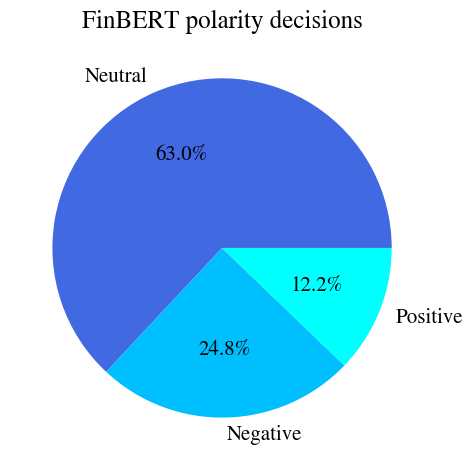

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(news.Sentiment_F2.value_counts(), labels=pd.Series([i for i in news.Sentiment_F2.unique()]).map({1: "Positive", 0:"Neutral", -1:"Negative"}), autopct='%1.1f%%', colors=["royalblue", "deepskyblue", "cyan"])
plt.title("FinBERT polarity decisions")
plt.tight_layout()

#plt.savefig("/content/drive/MyDrive/Text mining/Finbert2/FinBERT_polarity.pdf")
plt.show()

## VADER

Now the VADER model will be implemented and the result will be stored inside the column Sentiment_Vader.

In [ ]:
analyser = SentimentIntensityAnalyzer()

sentiment_vader = (news.Headlines.apply(analyser.polarity_scores)).tolist()

#no need to use pickle because the function is very fast

In [ ]:
news["Sentiment_Vader"] = [1 if x["compound"]>=.33 else -1 if x["compound"]<=-.33 else 0 for x in sentiment_vader]

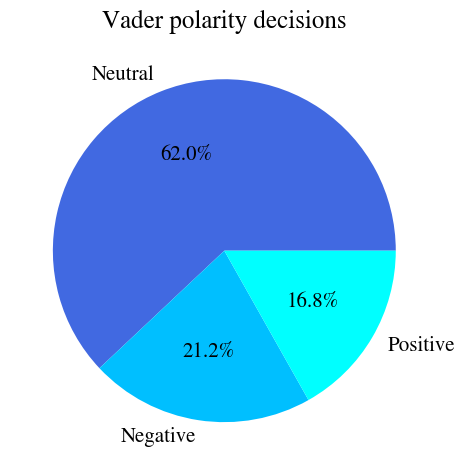

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(news.Sentiment_Vader.value_counts(), labels=[i for i in news.Sentiment_Vader.map({1:"Positive",0:"Neutral",-1:"Negative"}).value_counts().index], autopct='%1.1f%%', colors=["royalblue", "deepskyblue", "cyan"])
plt.title("Vader polarity decisions")
plt.tight_layout()

#plt.savefig("/content/drive/MyDrive/Text mining/Vader_polarity.pdf")
plt.show()

The following pie chart shows the differences between how the models labeled the headlines.

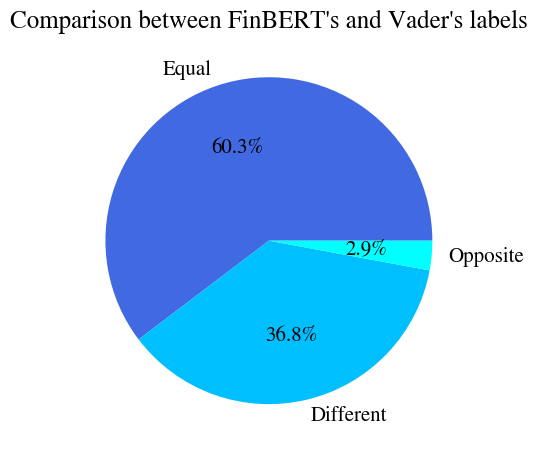

In [ ]:
comparison = []
for index, sentiments in news[["Sentiment_F2", "Sentiment_Vader"]].iterrows():
  if sentiments["Sentiment_F2"] == sentiments["Sentiment_Vader"]:
    comparison.append("Equal")
  elif abs(sentiments["Sentiment_F2"] - sentiments["Sentiment_Vader"])==2:
    comparison.append("Opposite")
  else:
    comparison.append("Different")

plt.pie(pd.Series(comparison).value_counts(), labels=[i.capitalize() for i in pd.Series(comparison).value_counts().index], autopct='%1.1f%%', colors=["royalblue", "deepskyblue", "cyan"])
plt.title("Comparison between FinBERT's and Vader's labels")
plt.tight_layout()
#plt.show()
plt.savefig("/content/drive/MyDrive/Text mining/Finbert2/comparison.pdf")

Now we save the average sentiment for each day in a column Avg_Sentiment_V and Avg_Sentiment_F2 of a dataset composed by, at the beginning, just a column for time.

In [ ]:
news_unique_time=pd.DataFrame({"Time":news.Time.unique()})
news_unique_time.reset_index(drop=True, inplace=True)

sent_list=list(news.groupby(by=["Time"]).Sentiment_Vader.apply(lambda x: x.mean()).reset_index()["Sentiment_Vader"])
news_unique_time["Avg_Sentiment_V"]=sent_list
sent_list=list(news.groupby(by=["Time"]).Sentiment_F2.apply(lambda x: x.mean()).reset_index()["Sentiment_F2"])
news_unique_time["Avg_Sentiment_F2"]=sent_list


We see that there are some non consecutive days for which there are no news available. These are stored in "missing_dates" and are manually added to the previously created dataset.
Then, the new dataset is re ordered so that the missing dates go where they should and do not stay at the beginning/end of the dataset.

In [ ]:
missing_dates = pd.Series([i for i in sp500["Date"] if i not in news_unique_time.Time.values])

news_unique_time = pd.concat([news_unique_time, pd.DataFrame({'Time':missing_dates,
        'Avg_Sentiment_V':[np.nan for i in range(len(missing_dates))],
        'Avg_Sentiment_F2':[np.nan for i in range(len(missing_dates))]
       })], ignore_index=True).sort_values(by="Time").reset_index(drop=True).copy()


In the following code we create two more columns in the sp500 dataset for FinBERT and VADER sentiments.
The process is divided in many steps:

1. if the date we are checking is inside missing_date, then we pick, as value of $t$, the average between $t+1$ and $t-1$;
1. if the date is in the news dataset but not in the sp500's one, it means that date was either a holiday or belonged to a weekend. Thus, that value is put inside a holder variable, respectively holder_F and holder_V and averaged to the sentiment of the first open-market day, hence with the first date for which exist a close value;
1. if the date is both in the sp500 dataset and in the news' one, it means that it is a normal day and thus the sentiment of that day can be written without any futher operation.

In [ ]:
holder_F=[]
holder_V=[]
sentiment_fin_day_F=[]
sentiment_fin_day_V=[]
available_dates=[]

for counter, date in enumerate(news_unique_time.Time.values):
  if date in missing_dates.values:
    sentiment_fin_day_F.append(np.average([news_unique_time.Avg_Sentiment_F2[counter-1], news_unique_time.Avg_Sentiment_F2[counter+1]]))
    sentiment_fin_day_V.append(np.average([news_unique_time.Avg_Sentiment_V[counter-1], news_unique_time.Avg_Sentiment_V[counter+1]]))
    available_dates.append(date)

  elif date in sp500.Date.values and holder_F!=[]: #either holder_F or holder_V, does not matter
    holder_F.append(news_unique_time.Avg_Sentiment_F2[counter])
    sentiment_fin_day_F.append(np.average(holder_F))
    holder_V.append(news_unique_time.Avg_Sentiment_V[counter])
    sentiment_fin_day_V.append(np.average(holder_V))
    available_dates.append(date)
    holder_F=[]
    holder_V=[]
  elif date in sp500.Date.values and holder_F==[]:
    sentiment_fin_day_F.append(news_unique_time.Avg_Sentiment_F2[counter])
    available_dates.append(date)
    sentiment_fin_day_V.append(news_unique_time.Avg_Sentiment_V[counter])
  else:
    holder_F.append(news_unique_time.Avg_Sentiment_F2[counter])
    holder_V.append(news_unique_time.Avg_Sentiment_V[counter])

sp500["Sentiment_fin_F2"]=sentiment_fin_day_F
sp500["Sentiment_fin_V"]=sentiment_fin_day_V

In [ ]:
#STD and mean of the two sentiments
print(np.std(sp500.Sentiment_fin_F2))
print(np.std(sp500.Sentiment_fin_V))

print(np.average(sp500.Sentiment_fin_F2))
print(np.average(sp500.Sentiment_fin_V))

0.08957086620036496
0.09205243036290303
-0.12298257534395945
-0.03913211788563956


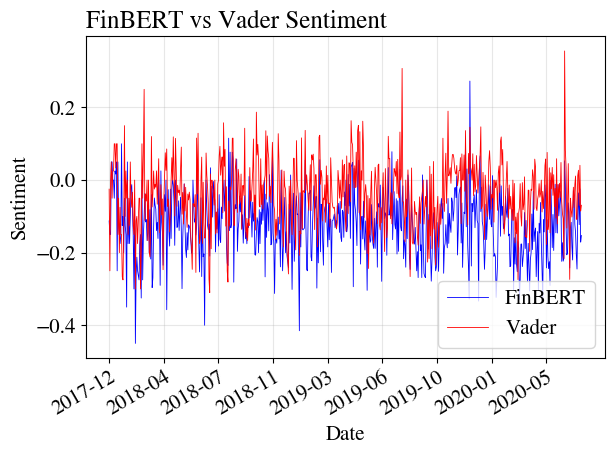

In [ ]:
#This chart shows the average sentiment for each day according to the two models
fig, ax1 = plt.subplots()

plt.grid(alpha=.3)
lns1 = ax1.plot(sp500.Date, sp500.Sentiment_fin_F2, 'blue', lw=.6, label="FinBERT")
lns3 = ax1.plot(sp500.Date, sp500.Sentiment_fin_V, 'red', lw=.6, label="Vader")

ax1.set_xticks(np.arange(0, 649,75))
ax1.set_xticklabels(pd.Series(sp500.Date)[::75].apply(lambda x: x[0:7]), rotation=30, ha="right", rotation_mode="anchor")

lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color='black')

plt.title("FinBERT vs Vader Sentiment", loc='left')
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/Text mining/Finbert2/FinBERT_vs_Vader_sentiment.pdf")

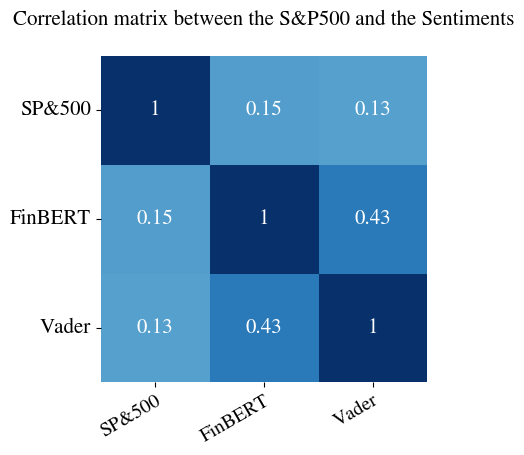

In [ ]:
# This heatmap shows the correlation between the sp500 and the two sentiments
sns.heatmap(sp500.drop(["Date", "Sentiment_fin_F"], axis=1).corr(), cmap=sns.color_palette("Blues", as_cmap=True), annot=True, vmin=-1, vmax=1, cbar=False, square=True)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=["SP&500", "FinBERT", "Vader"], size=14, rotation=30, ha="right", rotation_mode="anchor")
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=[ "SP&500",  "FinBERT", "Vader"], rotation=0)
plt.title("Correlation matrix between the S&P500 and the Sentiments\n", size=15)
plt.tight_layout()
plt.show()
#plt.savefig("/content/drive/MyDrive/Text mining/Finbert2/corr_variables_sp500.pdf")

In [ ]:
#Saving the file
sp500.to_csv("/content/drive/MyDrive/Text mining/sp500_w_sentiment.csv", index=False)

Moving to **R**!

In [ ]:
#The following lines are not to run the code again and again
#news = pd.read_csv("/content/drive/MyDrive/Text mining/news_w_sentiment.csv")
#sp500 = pd.read_csv("/content/drive/MyDrive/Text mining/sp500_w_sentiment.csv")